In [4]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

from scripts.dataPreprocessingPipeline import load_images_for_resnet, unlabeled_image_generator
from scripts.pseudoLabeling import active_semi_sumpervised_learning
from scripts.showImage import show_image, show_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.68..144.061].


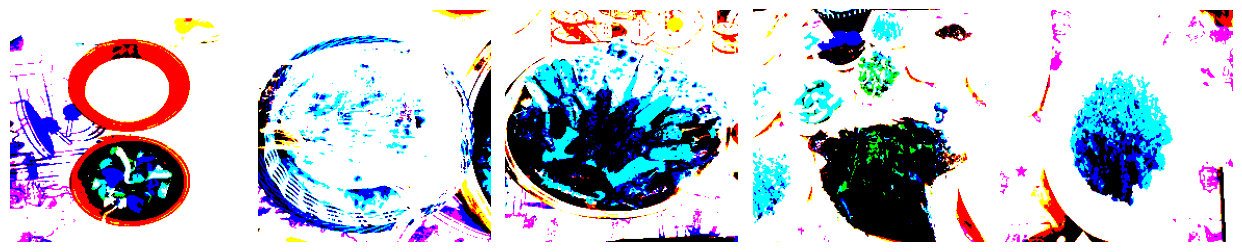

In [5]:
X_labeled, y_labeled, labels_list = load_images_for_resnet("../data/labeled")
show_images(X_labeled[:5])

In [6]:
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 85s 1us/step


In [7]:
NUM_CLASSES = len(labels_list)

new_model = models.Sequential([
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
new_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
history = new_model.fit(
    X_labeled, y_labeled,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2312 - loss: 2.0596 - val_accuracy: 0.0000e+00 - val_loss: 3.3025
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 772ms/step - accuracy: 0.5323 - loss: 1.3648 - val_accuracy: 0.0000e+00 - val_loss: 3.3579
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 773ms/step - accuracy: 0.6667 - loss: 0.9938 - val_accuracy: 0.0000e+00 - val_loss: 3.3699
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 781ms/step - accuracy: 0.7742 - loss: 0.7287 - val_accuracy: 0.0000e+00 - val_loss: 3.4335
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 779ms/step - accuracy: 0.8118 - loss: 0.6641 - val_accuracy: 0.0000e+00 - val_loss: 3.4625
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 788ms/step - accuracy: 0.8710 - loss: 0.4557 - val_accuracy: 0.0000e+00 - val_loss: 3.3950
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 789ms/step - accuracy: 0.8333 - loss: 0.4760 - val_accuracy: 0.0000e+00 - val_loss: 3.2632
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 790ms/step - accuracy: 0.8763 - loss: 0.3977 - val_ac

Now to semi-supervised + Active Learning part!

In [10]:
unlabeled_dataset = tf.data.Dataset.from_generator(
    lambda: unlabeled_image_generator("../data/unlabeled", batch_size=32),
    output_signature=(
        tf.TensorSpec(shape=(None,224,224,3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.string)
    )
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60.84..72.5305].


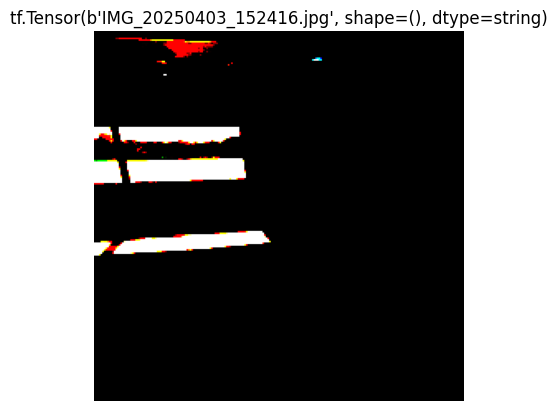

ValueError: invalid literal for int() with base 10: ''

In [11]:
pseudo_X, pseudo_y, manual_X, manual_y = active_semi_sumpervised_learning(
    new_model,
    unlabeled_dataset,
    threshold=0.9,
    batch_size=32,
)